In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import xarray as xr
import rasterio as rio
import rioxarray
import math, os
import pandas as pd
import geopandas as gpd
import xdem

### Let's make functions to see the distributions of our data among different topographic metrics and  fcf. We'll parse through all of our tiles to do so

In [22]:
aso_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/ASO_50M_SD_Merced_20220428_clean.tif"
fcf_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/fcf_for_ASO_50M_SD_Merced_20220428_clean.nc"
dem_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/cop30_for_ASO_50M_SD_Merced_20220428_clean.nc"
aso_ds = xr.open_dataset(aso_path)
aso_ds = aso_ds.rename({'band_data': 'aso_sd'})
fcf_ds = xr.open_dataset(fcf_path).rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
fcf_ds = fcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
dem_ds = xr.open_dataset(dem_path).rio.write_crs(aso_ds.rio.crs).rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
dem_ds = dem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})
transform = (50, 0.0, dem_ds.isel(x=0, y=0).x.item(), 0.0, 50, dem_ds.isel(x=0, y=0).y.item())
dem = xdem.DEM.from_array(dem_ds.elevation.values, transform, crs=dem_ds.rio.crs)
dem_ds['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)
ds = xr.merge([aso_ds, fcf_ds, dem_ds], compat='override', join='override').squeeze()

/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/geoutils/raster/raster.py:1427: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


In [37]:
# subset to only include data within the 2nd and 98th percentiles and drop nulls
q02 = ds.quantile(0.02, dim=['x', 'y'])
q98 = ds.quantile(0.98, dim=['x', 'y'])
ds_subset = ds.where((ds >= q02) & (ds <= q98) & ds.notnull(), drop=True)

In [ ]:
# only get values where snowdepth is greater than 0
ds_subset_snowon = ds_subset.where(ds_subset.aso_sd > 0, drop=True)

/tmp/ipykernel_19124/1140210454.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())]


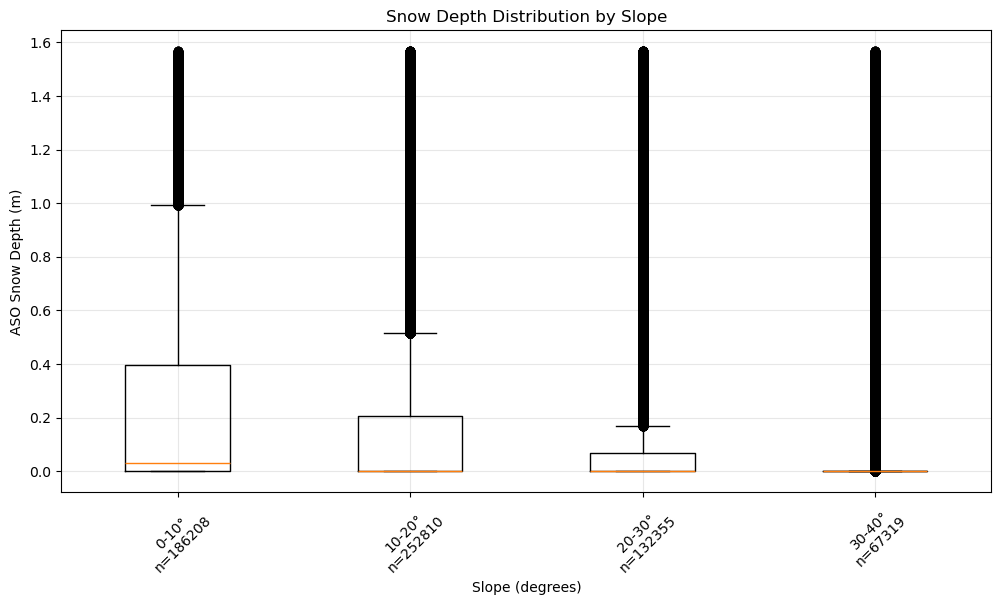

In [ ]:
# slope for all
slope_bins = np.arange(0, 41, 10)
slope_labels = [f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())])}' for i in range(len(slope_bins)-1)]
plt.figure(figsize=(12, 6))
plt.boxplot([ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())]
             for i in range(len(slope_bins)-1)],
            labels=slope_labels)
plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_19124/2231435692.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten())]


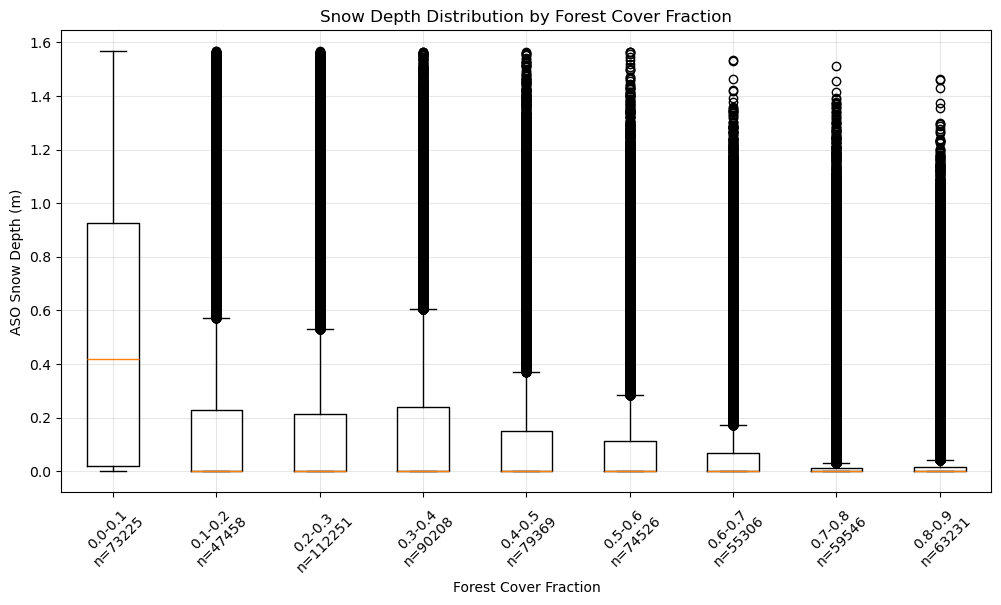

In [63]:
# fcf
fcf_bins = np.arange(0, 0.91, 0.1)
fcf_labels = [f'{fcf_bins[i]:.1f}-{fcf_bins[i+1]:.1f}\nn={len(ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten())])}' for i in range(len(fcf_bins)-1)]
plt.figure(figsize=(12, 6))
plt.boxplot([ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten())]
             for i in range(len(fcf_bins)-1)],
            labels=fcf_labels)
plt.xlabel('Forest Cover Fraction')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

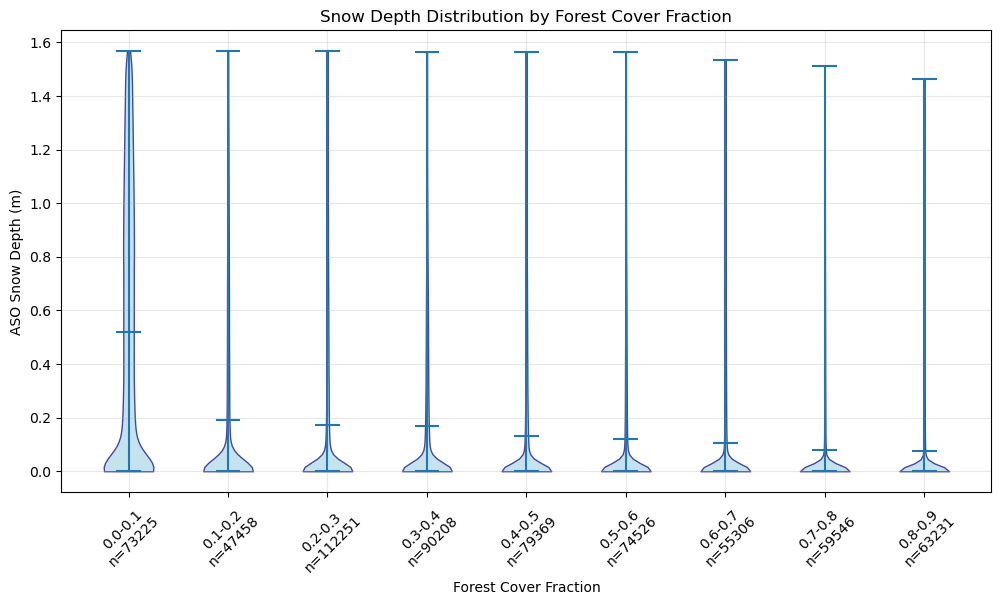

In [ ]:
fcf_bins = np.arange(0, 1.1, 0.1)
violin_data = []
fcf_labels = []
for i in range(len(fcf_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:  # Only include bins with data
        violin_data.append(data)
        fcf_labels.append(f'{fcf_bins[i]:.1f}-{fcf_bins[i+1]:.1f}\nn={len(data)}')
plt.figure(figsize=(12, 6))
parts = plt.violinplot(violin_data, showmeans=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('navy')
plt.xticks(range(1, len(violin_data) + 1), fcf_labels, rotation=45)
plt.xlabel('Forest Cover Fraction')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction')
plt.grid(True, alpha=0.3)

/tmp/ipykernel_19124/2930950352.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten())]


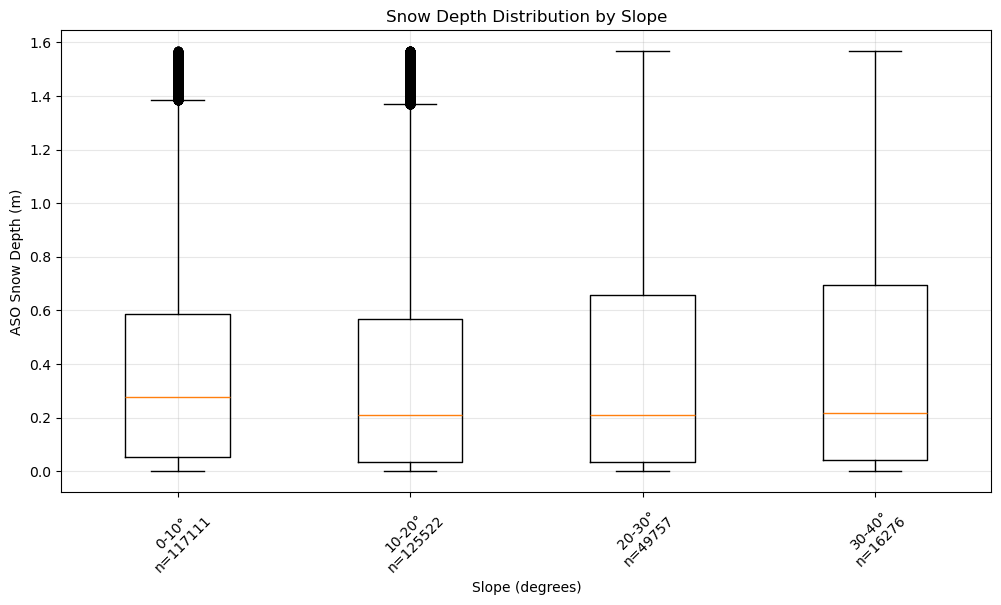

In [ ]:
# slope snowon
slope_bins = np.arange(0, 41, 10)
slope_labels = [f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten())])}' for i in range(len(slope_bins)-1)]
plt.figure(figsize=(12, 6))
plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten())]
             for i in range(len(slope_bins)-1)],
            labels=slope_labels)
plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_19124/2513675273.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten())]


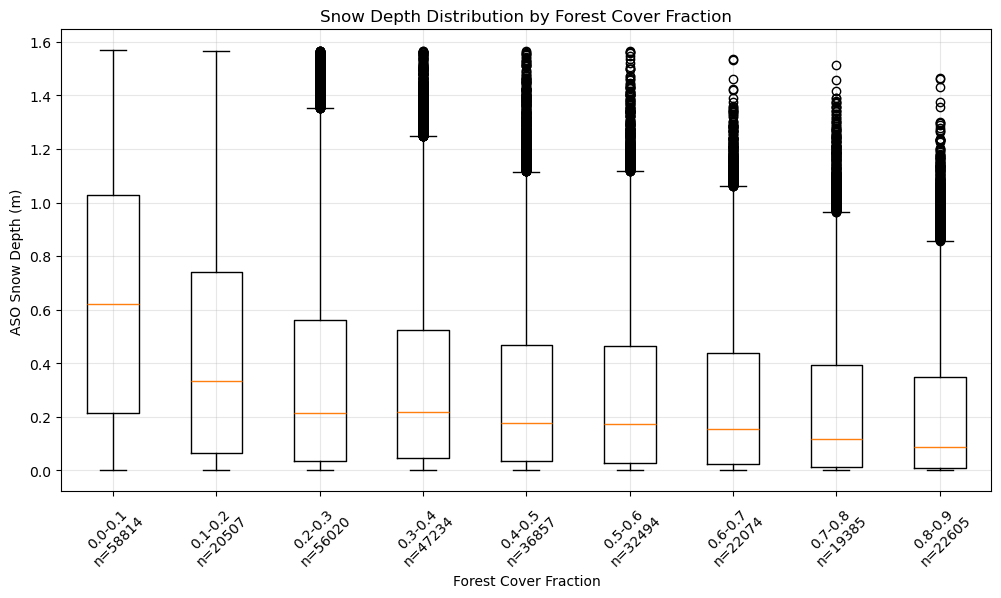

In [64]:
# fcf snowon
fcf_bins = np.arange(0, 0.91, 0.1)
fcf_labels = [f'{fcf_bins[i]:.1f}-{fcf_bins[i+1]:.1f}\nn={len(ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten())])}' for i in range(len(fcf_bins)-1)]
plt.figure(figsize=(12, 6))
plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten())]
             for i in range(len(fcf_bins)-1)],
            labels=fcf_labels)
plt.xlabel('Forest Cover Fraction')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

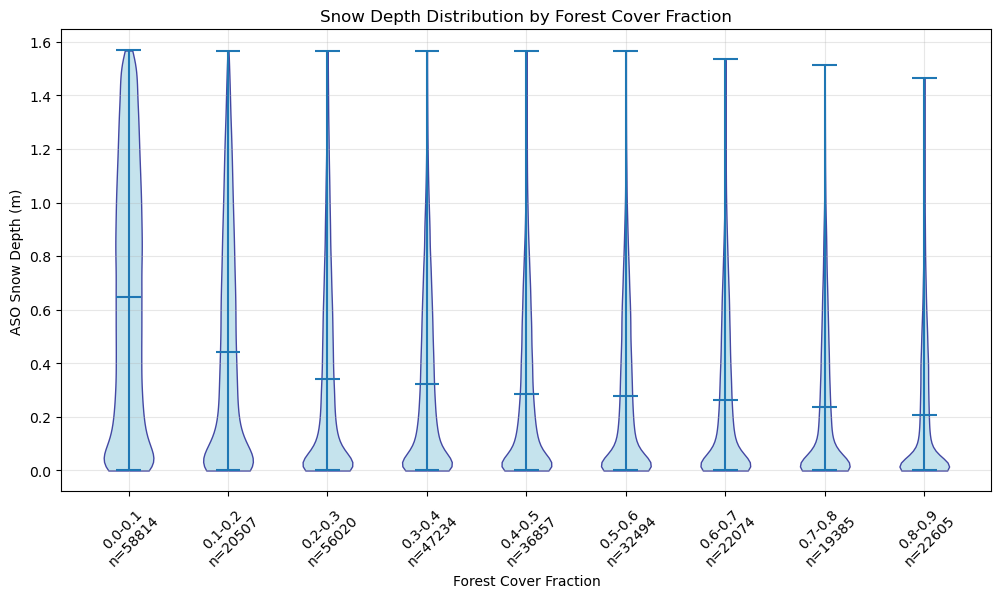

In [68]:
fcf_bins = np.arange(0, 1.1, 0.1)
violin_data = []
fcf_labels = []
for i in range(len(fcf_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:  # Only include bins with data
        violin_data.append(data)
        fcf_labels.append(f'{fcf_bins[i]:.1f}-{fcf_bins[i+1]:.1f}\nn={len(data)}')
plt.figure(figsize=(12, 6))
parts = plt.violinplot(violin_data, showmeans=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('navy')
plt.xticks(range(1, len(violin_data) + 1), fcf_labels, rotation=45)
plt.xlabel('Forest Cover Fraction')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction')
plt.grid(True, alpha=0.3)